In [2]:
# Fill in your name using the format below and student ID number
your_name = "BALTUS, NORA"
student_id = "1000558"

In [3]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [4]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [5]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
devices = tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available
tf.config.experimental.set_memory_growth(devices[0], True) # Fixes a CUDA issue

devices # List the devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [7]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi NORA, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [8]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [9]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [10]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [11]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [12]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [13]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

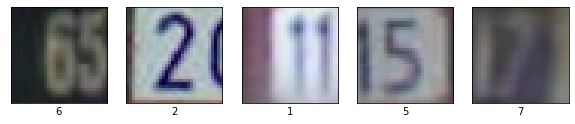

In [14]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
        return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
        return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

In [16]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

# def build_toy_model():
#     model = models.Sequential()
#     model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))
#     model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# First build and store
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
#                train=True, epochs=3, batch_size=32)

In [135]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
# run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
#                train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/30
63544/63544 [==============================] - 6s 92us/sample - loss: 2.0365 - accuracy: 0.2872 - val_loss: 1.6373 - val_accuracy: 0.4579
Epoch 2/30
63544/63544 [==============================] - 6s 93us/sample - loss: 1.4403 - accuracy: 0.5368 - val_loss: 1.3186 - val_accuracy: 0.5849
Epoch 3/30
63544/63544 [==============================] - 6s 87us/sample - loss: 1.1886 - accuracy: 0.6311 - val_loss: 1.1148 - val_accuracy: 0.6581
Epoch 4/30
63544/63544 [==============================] - 6s 97us/sample - loss: 1.0677 - accuracy: 0.6691 - val_loss: 1.0726 - val_accuracy: 0.6665
Epoch 5/30
63544/63544 [==============================] - 6s 90us/sample - loss: 0.9850 - accuracy: 0.6971 - val_loss: 1.0105 - val_accuracy: 0.6908
Epoch 6/30
63544/63544 [==============================] - 6s 87us/sample - loss: 0.9215 - accuracy: 0.7170 - val_loss: 0.9642 - val_accuracy: 0.6994
Epoch 7/30
63544/63544 [=============

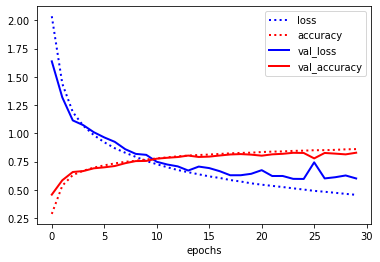

In [136]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=30, batch_size=32)

answer_q_1_1 = """
Several optimizers (rmsprop, adam, adagrad, sgd) were tested in combination with different batch sizes. 
Adagrad gave the cleanest results but it converged quickly without reaching the required minimum accuracy.
A higher accuracy was achieved using adam but it started overfitting quickly. When comparing rmsprop to sgd, 
sgd performed the best with an accuracy of up to 0.83. I have chosen to stick to three simple deep layers 
to avoid making the model so complex that it starts to overfit.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [137]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/30
63544/63544 [==============================] - 6s 88us/sample - loss: 2.0992 - accuracy: 0.2586 - val_loss: 1.8579 - val_accuracy: 0.3831
Epoch 2/30
63544/63544 [==============================] - 6s 93us/sample - loss: 1.5941 - accuracy: 0.4707 - val_loss: 1.4709 - val_accuracy: 0.5298
Epoch 3/30
63544/63544 [==============================] - 6s 89us/sample - loss: 1.2977 - accuracy: 0.5914 - val_loss: 1.1620 - val_accuracy: 0.6448
Epoch 4/30
63544/63544 [==============================] - 5s 83us/sample - loss: 1.1251 - accuracy: 0.6524 - val_loss: 1.0514 - val_accuracy: 0.6812
Epoch 5/30
63544/63544 [==============================] - 5s 80us/sample - loss: 1.0241 - accuracy: 0.6851 - val_loss: 1.0038 - val_accuracy: 0.6935
Epoch 6/30
63544/63544 [==============================] - 5s 80us/sample - loss: 0.9518 - accuracy: 0.7079 - val_loss: 0.9620 - val_accuracy: 0.7123
Epoch 7/30
63544/63544 [=============

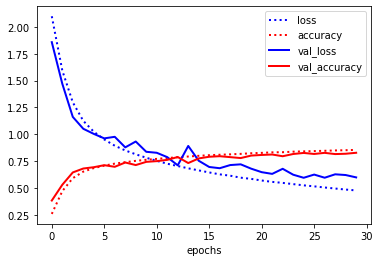

In [138]:
# Replace with the preprocessed data
X_train_preprocessed = rgb2gray(X_train)
X_val_preprocessed = rgb2gray(X_val)

preprocessed_split = X_train_preprocessed, X_val_preprocessed, y_train, y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=30, batch_size=32)

answer_q_1_2 = """
I have chosen to preprocess using only the grayscale converter.
I initially expected this model to perform slightly better, but it appeared to perform
equally well. This could be explained by the fact that classifying numbers depends more 
on the shapes the model can learn to recognize rather than the color differences.
However, the loss function appears to be smoother when using grayscaled data. """

print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 5s 84us/sample - loss: 2.1155 - accuracy: 0.2355 - val_loss: 1.9285 - val_accuracy: 0.2931
Epoch 2/50
63544/63544 [==============================] - 3s 47us/sample - loss: 1.6963 - accuracy: 0.4176 - val_loss: 1.4250 - val_accuracy: 0.5374
Epoch 3/50
63544/63544 [==============================] - 3s 47us/sample - loss: 1.4459 - accuracy: 0.5210 - val_loss: 1.3943 - val_accuracy: 0.5350
Epoch 4/50
63544/63544 [==============================] - 3s 46us/sample - loss: 1.2985 - accuracy: 0.5791 - val_loss: 1.1079 - val_accuracy: 0.6606
Epoch 5/50
63544/63544 [==============================] - 3s 46us/sample - loss: 1.2082 - accuracy: 0.6144 - val_loss: 1.0193 - val_accuracy: 0.6940
Epoch 6/50
63544/63544 [==============================] - 3s 51us/sample - loss: 1.1291 - accuracy: 0.6417 - val_loss: 0.9383 - val_accuracy: 0.7115
Epoch 7/50
63544/63544 [=============

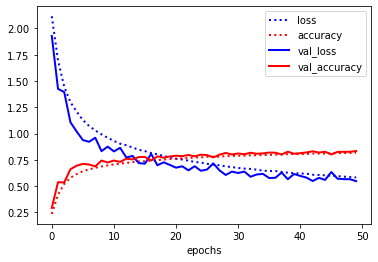

In [150]:
from tensorflow.keras import optimizers, regularizers

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# from sklearn.model_selection import GridSearchCV

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.20))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.20))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.20))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# clf = KerasClassifier(build_model_1_3)
# param_grid = {
#     'epochs': [5],
#     'dropout_1': [0.1, 0.15, 0.20],
#     'dropout_2': [0.1, 0.15, 0.20],
#     'dropout_3': [0.1, 0.15, 0.20],
#     'verbose': [1]
# }
# grid = GridSearchCV(clf, param_grid=param_grid, cv=3, return_train_score=True)
# grid.fit(rgb2gray(X_train), y_train)

# res = pd.DataFrame(grid.cv_results_)
# res.pivot_table(index=["param_epochs", "param_dropout_1", "param_dropout_2", "param_dropout_3"],
#                 values=["mean_train_score", "mean_test_score"])

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)

answer_q_1_3 = """
To regularize the model, dropouts are added after layers to discard a 
percentage of the results. To test which dropout values work best, a gridsearch was done
for [0.1, 0.15, 0.20] as earlier tests indicated that smaller values gave better results.
Both l1 and l2 performed much worse than using dropouts alone. A learning rate of 0.1 was
found to perform better than smaller rates. The accuracy improved slightly and the learning
curves are much smoother. There appears to be less overfitting. """

print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/20
63544/63544 [==============================] - 6s 96us/sample - loss: 1.1802 - accuracy: 0.6135 - val_loss: 0.6756 - val_accuracy: 0.7973
Epoch 2/20
63544/63544 [==============================] - 5s 80us/sample - loss: 0.5567 - accuracy: 0.8327 - val_loss: 0.4074 - val_accuracy: 0.8790
Epoch 3/20
63544/63544 [==============================] - 5s 82us/sample - loss: 0.4325 - accuracy: 0.8702 - val_loss: 0.3812 - val_accuracy: 0.8872
Epoch 4/20
63544/63544 [==============================] - 6s 87us/sample - loss: 0.3717 - accuracy: 0.8888 - val_loss: 0.3257 - val_accuracy: 0.9031
Epoch 5/20
63544/63544 [==============================] - 6s 93us/sample - loss: 0.3325 - accuracy: 0.9013 - val_loss: 0.3656 - val_accuracy: 0.8952
Epoch 6/20
63544/63544 [==============================] - 6s 87us/sample - loss: 0.3059 - accuracy: 0.9093 - val_loss: 0.3152 - val_accuracy: 0.9066
Epoch 7/20
63544/63544 [=============

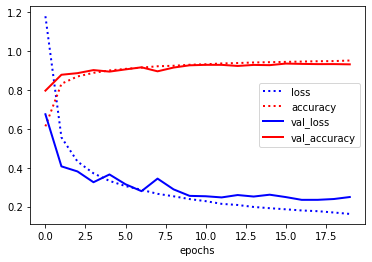

In [159]:
def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (2,2), activation='relu'))
    model.add(layers.Conv2D(64, (2,2), activation='relu'))
    model.add(layers.Conv2D(64, (2,2), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=20, batch_size=128)

answer_q_2_1 = """
When making this model, I followed the guideline to use enough filters in the first layer 
to not lose information and to use more filters in deeper layers. A lot of hyperparameter choices, 
such as the learning rate and dropout were based on experimenting with different settings. 
Initially I included more conv2d layers, but the model started overfitting much faster. 
I decided not to use padding=same everywhere because in most cases only the number in the 
center is of actual importance. I also experimented with pooling layers and found this setup 
to be the most successful. For deeper layers I chose a smaller stride length, to maintain enough 
information from the pooling layer. The model performs ok, but showing slight signs of overfitting. """

print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Training the model
  ...
    to  
  ['...']
Train for 512 steps, validate on 15887 samples
Epoch 1/20
512/512 [==============================] - 6s 11ms/step - loss: 2.1570 - accuracy: 0.2273 - val_loss: 1.4255 - val_accuracy: 0.5569
Epoch 2/20
512/512 [==============================] - 5s 10ms/step - loss: 1.5061 - accuracy: 0.5012 - val_loss: 0.8368 - val_accuracy: 0.7497
Epoch 3/20
512/512 [==============================] - 5s 10ms/step - loss: 1.1754 - accuracy: 0.6238 - val_loss: 0.6453 - val_accuracy: 0.8053
Epoch 4/20
512/512 [==============================] - 5s 10ms/step - loss: 0.9962 - accuracy: 0.6857 - val_loss: 0.5798 - val_accuracy: 0.8278
Epoch 5/20
512/512 [==============================] - 5s 10ms/step - loss: 0.9151 - accuracy: 0.7090 - val_loss: 0.4781 - val_accuracy: 0.8569
Epoch 6/20
512/512 [==============================] - 5s 10ms/step - loss: 0.8307 - accuracy: 0.7380 - val_loss: 0.5631 - val_accuracy: 0.8365
Epoch 7/20
512/512 [==============================]

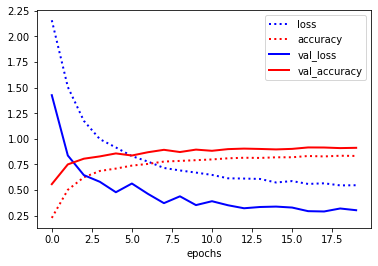

In [160]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data

train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range=0.2,
)

train_generator = train_datagen.flow(X_train_preprocessed, y_train)
augmented_split = train_generator, X_val_preprocessed, y_val

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, epochs=20, batch_size=None, generator=True, steps_per_epoch=512)

answer_q_2_2 = """
The goal of data augmentation is to train the model with more varied inputs to improve
the accuracy of classifying real data. I've looked at many input examples and found that
the numbers are often tilted or not entirely centered. The model is slightly less accurate, 
rather than more accurate. The lack of an augmentation effect could indicate that the data 
that was passed was already quite diverse."""

print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

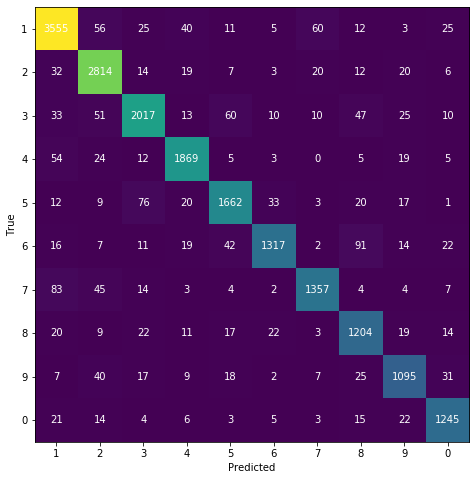

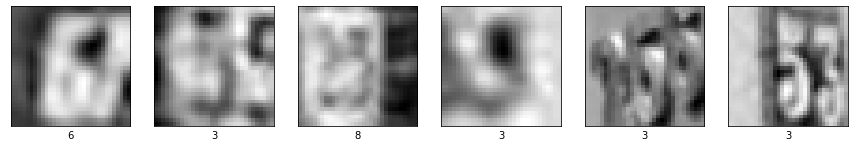

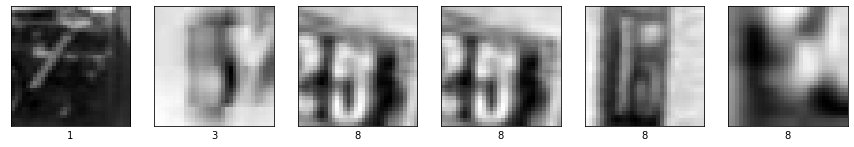

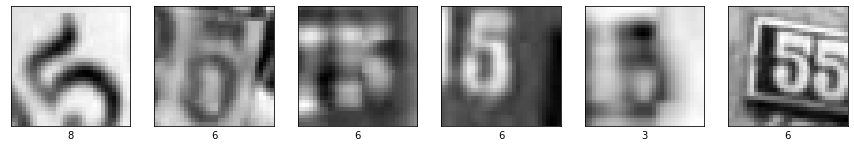

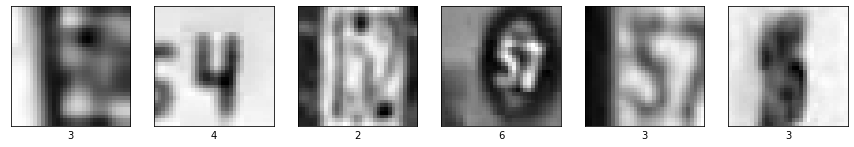

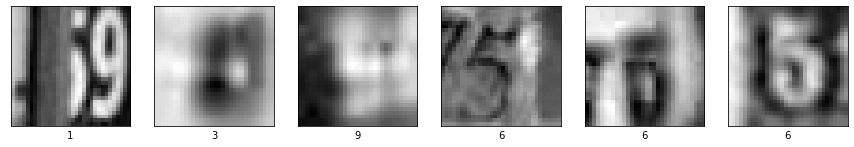

Answer is 479 characters long


In [161]:
from sklearn.metrics import confusion_matrix

test_accuracy_3_1 = 0.918802

model = load_model_from_file("./", "model_2_2")
X_test_gray = rgb2gray(X_test)
y_pred = model.predict(X_test_gray)

def plot_confusion_matrix():
    classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(10):
        for j in range(10):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color="w")

def plot_misclassifications():
    num_cases = 5 # The number of misclassifications to analyze
    misclassification_class = 4 # The number to analyze (this is the index!)
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
    misclassified_samples_of_class = []
    
    while len(misclassified_samples_of_class) <= num_cases:
        i = randint(0, len(misclassified_samples) - 1)
        if np.argmax(y_test[misclassified_samples[i]]) == misclassification_class:
            misclassified_samples_of_class.append(misclassified_samples[i])
            
    fig, axes = plt.subplots(1, num_cases + 1,  figsize=(15, 5))
    for i in range(len(misclassified_samples_of_class)):
        axes[i].imshow(X_test_gray[misclassified_samples_of_class[i]].squeeze(), cmap='gray')
        axes[i].set_xlabel((np.argmax(y_pred[misclassified_samples_of_class[i]]) + 1) % 10)
        axes[i].set_xticks(()), axes[i].set_yticks(())
        
    plt.show();

plot_confusion_matrix()

for i in range(5):
    plot_misclassifications()

answer_q_3_1 = """
The heatmap shows that a 1 is often misclassified as being either a 7, which could be 
explained by the prominent straight line in both the numbers 7 and 1. The images below
illustrate the misclassifications of 5. In some cases such there is no way the algorithm 
would have known the number was a 5. In other cases, it often gets mistaken for the 3 due
to its bottom round shape and a 6 which could mean the model has not picked up on the 
closed shape of 6. """

print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

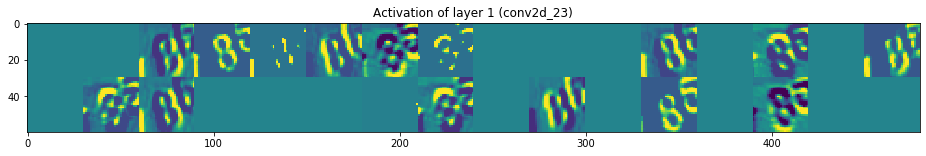

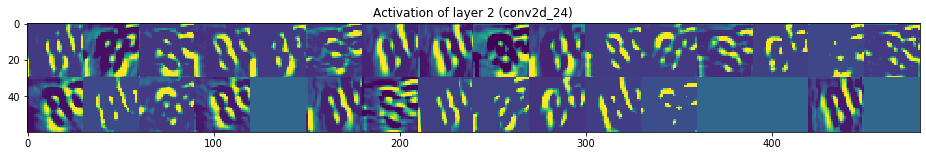

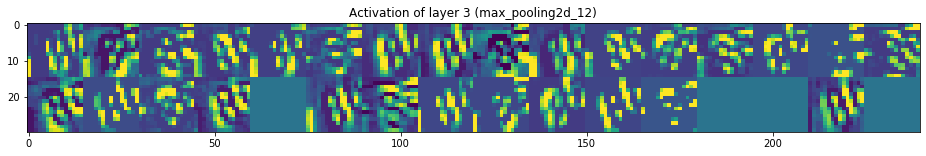

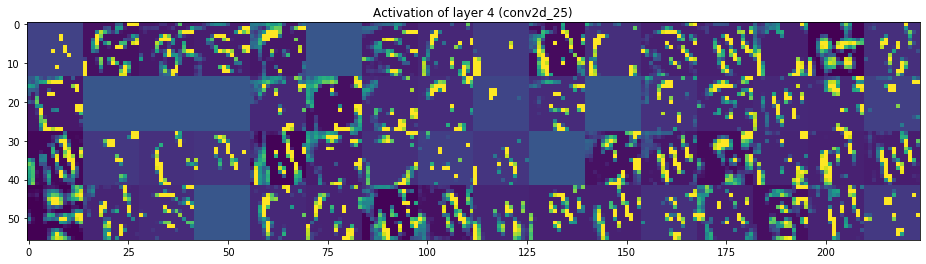

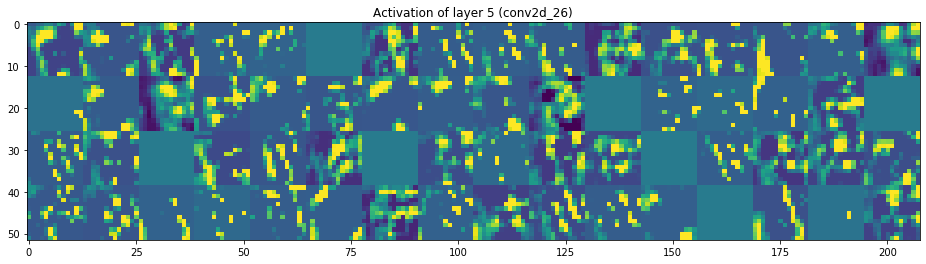

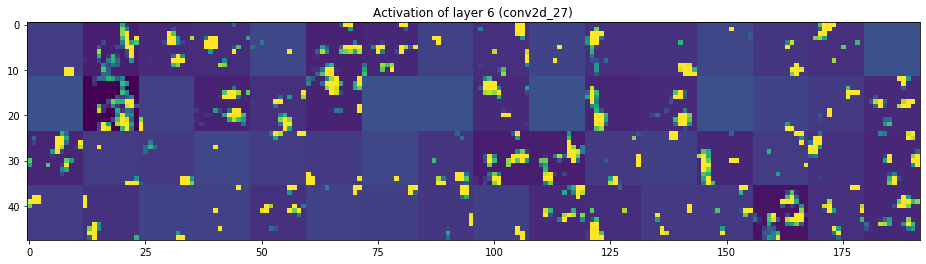

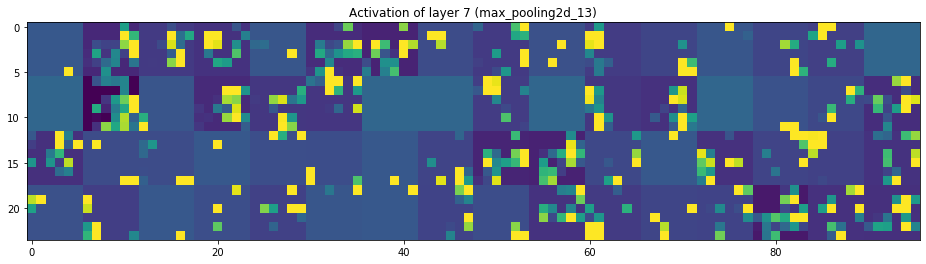

Answer is 374 characters long


In [165]:
# Based on the code from Notebook 6
def plot_activations_helper(layer_index, model_layers, activations):
    start = layer_index
    end = layer_index+1
    
    num_layers = 7
    images_per_row = 16
    
    layer_names = []
    for layer in model_layers[:num_layers]:
        layer_names.append(layer.name)
    
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                if channel_image.std() != 0:
                    channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
    
def plot_activations():
    model = load_model_from_file("./", "model_2_2")
    # Based on the code from Notebook 6
    img_tensor = rgb2gray(X_test)[0]
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    # Extracts the output of all layers
    layer_outputs = [layer.output for layer in model.layers]
    # Model that can return the outputs
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)

    for i in range(len(model.layers)):
        plot_activations_helper(i, model.layers, activations)
        
plot_activations()
    
answer_q_3_2 = """
In the first four layers, the model is indeed learning something useful. 
It clearly distinguishes the shape of the number 8. Starting from layer four, 
only some features are useful as others focus on the bordering parts of the image
rather than the shape that is at the center. The activations of the final two
layers are less useful as they could pertain to any number. """

print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

<Figure size 432x288 with 0 Axes>

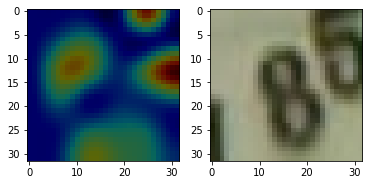

In [164]:
import matplotlib.cm as cm
from vis.utils import utils
from vis.visualization import visualize_cam, overlay

def plot_3_3():
    model = load_model_from_file("./", "model_2_2")
    
    index = 0 # The index of the image that is looked at
    layer_idx_name = 'dense_43'
    penultimate_layer_idx_name = 'max_pooling2d_13'
    
    plt.figure()
    fig, ax = plt.subplots(1, 2)
    grad= visualize_cam(model, seed_input=rgb2gray(X_test)[index], 
                        layer_idx=utils.find_layer_idx(model, layer_idx_name), 
                        penultimate_layer_idx=utils.find_layer_idx(model, penultimate_layer_idx_name),
                        filter_indices=np.argmax(y_test))
    heatmap = np.uint(cm.jet(grad)[..., :3] * 255)
    ax[0].imshow(overlay(heatmap, X_test[index], alpha=0.4))
    ax[1].imshow(X_test[index])

plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/5
63544/63544 [==============================] - 37s 581us/sample - loss: 1.0301 - accuracy: 0.6493 - val_loss: 0.9004 - val_accuracy: 0.6969
Epoch 2/5
63544/63544 [==============================] - 39s 608us/sample - loss: 0.7044 - accuracy: 0.7638 - val_loss: 0.6567 - val_accuracy: 0.7812
Epoch 3/5
63544/63544 [==============================] - 38s 605us/sample - loss: 0.6040 - accuracy: 0.7986 - val_loss: 0.6105 - val_accuracy: 0.7981
Epoch 4/5
63544/63544 [==============================] - 39s 607us/sample - loss: 0.5339 - accuracy: 0.8246 - val_loss: 0.6305 - val_accuracy: 0.7999
Epoch 5/5
63544/63544 [==============================] - 39s 617us/sample - loss: 0.4846 - accuracy: 0.8406 - val_loss: 0.6178 - val_accuracy: 0.8010
Saving to file
Model stored in ./
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Para

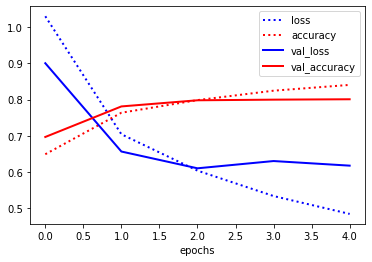

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16

def build_model_4_1():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
    
    # 19 layers
    for layer in conv_base.layers[:15]:
        layer.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=5, batch_size=64)

answer_q_4_1 = """ 
The accuracy of the model appeared to increase along with the unfreezing of convolutional base layers. 
The overall performance is not as good as expected, but this could be explained by the fact that 
no data augmentation was used for this exercise. Also no forms of regularization were used for the dense layer, 
which could explain why the model starts overfitting fast at higher epochs. """

print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [18]:
import pickle
import gzip

from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer


def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file """
    model = load_model_from_file("./", "model_4_1")
    new_model = model.layers[0]

    if not os.path.isfile('./train_embedding.p'):
        store_embedding(new_model.predict(X_train), 'train')
    if not os.path.isfile('./test_embedding.p'):
        store_embedding(new_model.predict(X_test), 'test')
    
    print('Embeddings stored')

def generate_pipeline():
    """ Returns an sklearn pipeline. """
    clf = svm.SVC(kernel='rbf')
    
    steps = [('encoder', FunctionTransformer(np.argmax))]
    pre_pipeline = Pipeline(steps=steps)
    preprocessor = ColumnTransformer(
        transformers=(), remainder=pre_pipeline)
    
    pipeline = Pipeline([('classifier', clf)])
    return pipeline

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score. """
    return np.mean(cross_val_score(pipeline, X_test, y_test))

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data and returns the accuracy. """
    if not os.path.isfile('./train_embedding.p'):
        store_embeddings()
        
    if not os.path.isfile('./test_embedding.p'):
        store_embeddings()
        
    loaded_train = load_embedding('train')
    loaded_test = load_embedding('test')
    
    pipeline = generate_pipeline()
    return evaluate_pipeline(pipeline, loaded_train, y_train, loaded_test, y_test)

accuracy = evaluation_4_2(X_train, y_train, X_test, y_test)
print("Accuracy:", accuracy)

answer_q_4_2 = """
I did not manage to get this to work because of errors, but most of the code is in place. """

print("Pipeline:", generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Accuracy: nan
Pipeline: Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Answer is 91 characters long


C:\Users\norab\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (15886, 10)

  FitFailedWarning)
C:\Users\norab\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (15886, 10)

  FitFailedWarning)
C:\Users\norab\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: bad input shape (15886, 10)

  FitFailedWarning)
C:\Users\norab\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition 